In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from pymongo import MongoClient

from src.config_tickets import ticket_lst
from src.scraping import WebScraping
from src.settings import HOST
from src.query_data import QueryData
from src.utilities import run_model_with_parameters, run_model_without_parameters

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [4]:
def connect_2_dbServer():
    mongoClient = MongoClient(HOST)
    return mongoClient

In [5]:
client = connect_2_dbServer()
query = QueryData(client)

In [6]:
lst_ticket = query.get_list_ticket(index='VN 30 (VNI30)')
print(lst_ticket)
print(len(lst_ticket))

['Ho Chi Minh City Infrastructure Investment JSC', 'Ho Chi Minh City Development Joint Stock Commercial Bank', 'Hoa Phat Group JSC', 'Masan Group Corp', 'Military Commercial Joint Stock Bank', 'Mobile World Investment Corp', 'No Va Land Investment Group Corp', 'PetroVietnam Fertilizer and Chemicals Corp', 'Phu Nhuan Jewelry JSC', 'Refrigeration Electrical Engineering Corp', 'Sai Gon Thuong Tin Commercial Joint Stock Bank', 'Saigon Beer Alcohol Beverage Corp', 'Saigon Securities Incorporation', 'Vietnam Technological And Commercial Joint Stock Bank', 'Thanh Thanh Cong Tay Ninh JSC', 'Joint Stock Commercial Bank for Foreign Trade of Vietnam', 'Vietjet Aviation JSC', 'Vietnam Export Import Commercial Joint Stock Bank', 'Vietnam JSCmmercial Bank for Industry and Trade', 'Vietnam Prosperity Joint Stock Commercial Bank', 'Vietnam Dairy Products JSC', 'Vincom Retail JSC', 'Vingroup JSC', 'Vinhomes JSC', 'Petrovietnam Gas JSC']
25


In [7]:
start = datetime(2010,1,1)
end = datetime(2019,1,1)

print(lst_ticket[:5])

df = query.get_historical_data(lst_ticket[:5], start=start)
closed_price = dict()
for ticket in lst_ticket[:5]:
    closed_price[ticket] = df[df.name == ticket]['close']

['Ho Chi Minh City Infrastructure Investment JSC', 'Ho Chi Minh City Development Joint Stock Commercial Bank', 'Hoa Phat Group JSC', 'Masan Group Corp', 'Military Commercial Joint Stock Bank']


## Plot ACF and PACF

In [8]:
from statsmodels.tsa.stattools import pacf, acf

def calculate_acf(time_series, lag=20, alpha=0.01):
    x = time_series.values
    acf_value, confint = acf(x, nlags=lag, alpha=alpha)
    confint_lower = confint[:, 0] - acf_value
    confint_upper = confint[:, 1] - acf_value
    return acf_value, confint_upper, confint_lower


def calculate_pacf(time_series, lag=20, alpha=0.01):
    x = time_series.values
    pacf_value, confint = pacf(x, nlags=lag, alpha=alpha)
    confint_lower = confint[:, 0] - pacf_value
    confint_upper = confint[:, 1] - pacf_value
    return pacf_value, confint_upper, confint_lower

## Run model

### ARIMA model

Masan Group Corp
Training result: {'mse': 1781053.203866894, 'rmse': 1334.561052881019, 'mae': 941.8055083037731, 'mape': 1.1344706365203767}
Testing result: {'mse': 821438.7287179008, 'rmse': 906.3325707034371, 'mae': 686.3204576330122, 'mape': 0.7858461933227401}


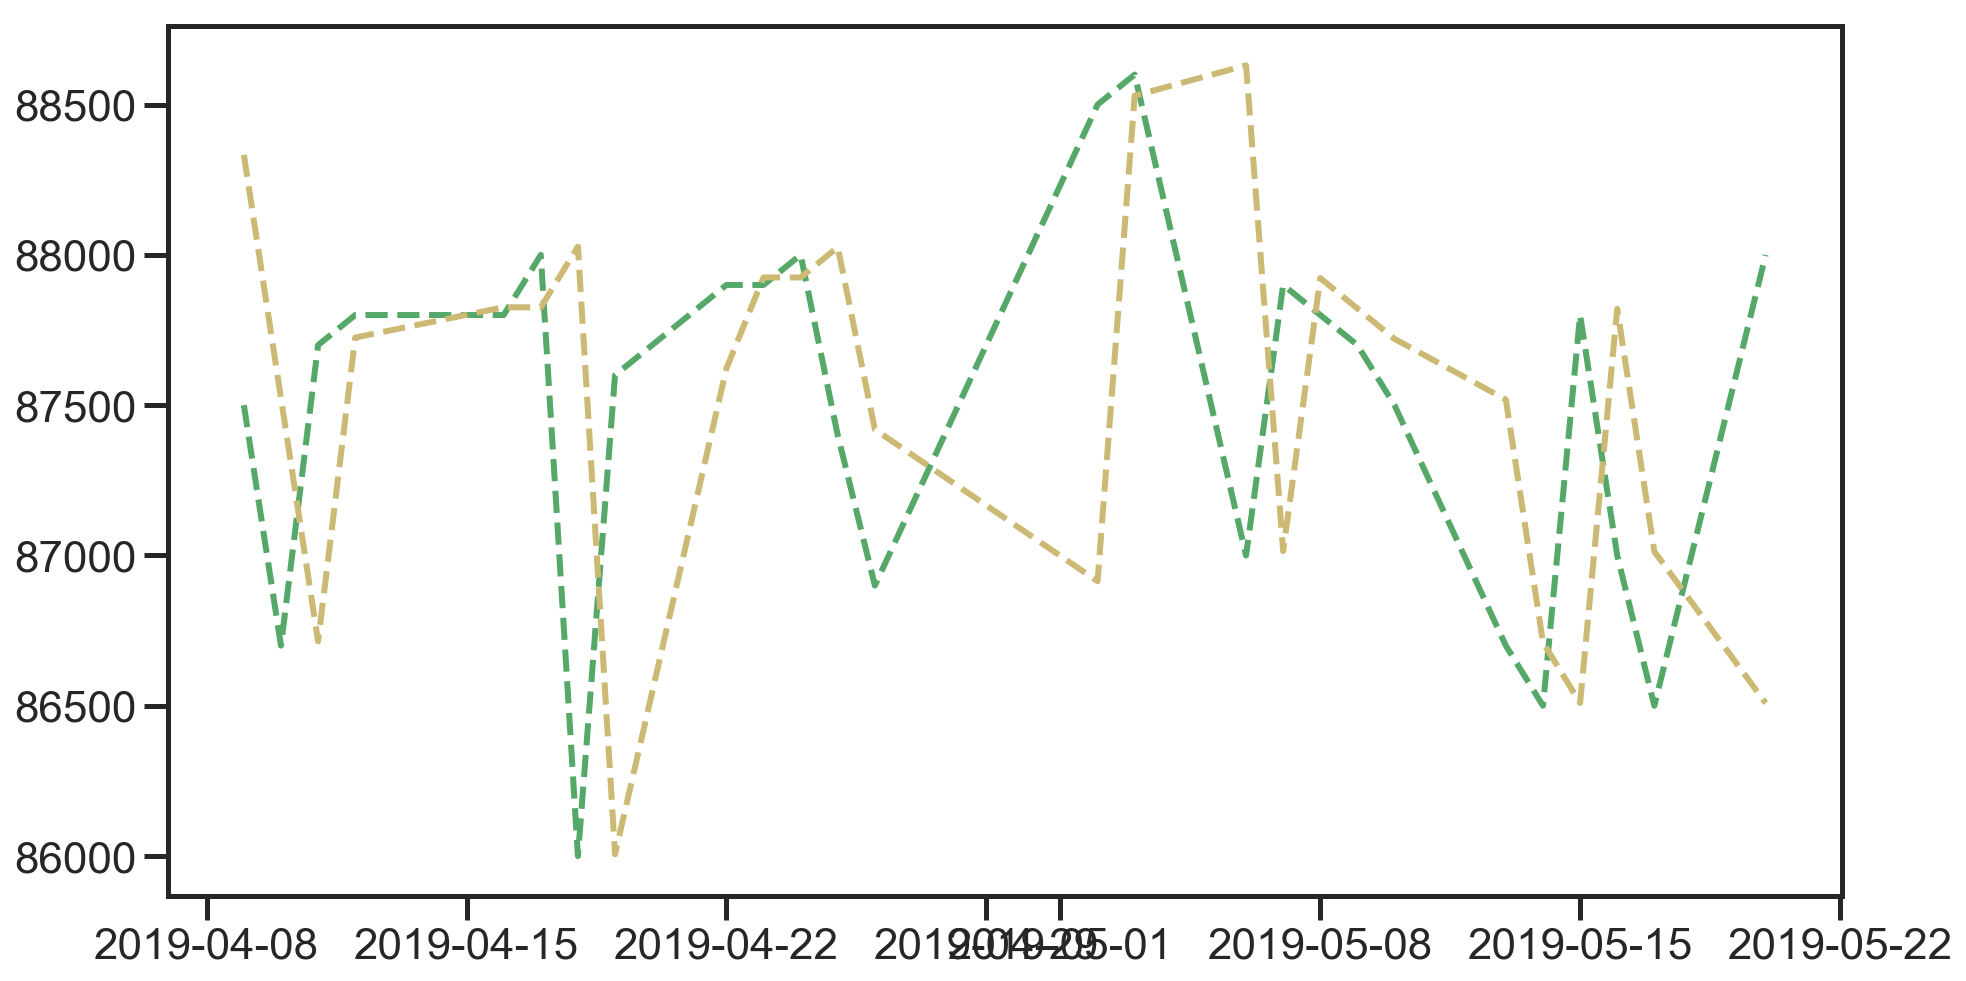

In [12]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    start_train = 0.9
    end_train = 0.98
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result = run_model_with_parameters(train, test, model_selection='ARIMA', order=(1,0,0))
    if result['status']:
        validation = result['model'].validate(test)
        time.sleep(1)
        print(ticket)
        print('Training result:', result['train_evaluation'])
        print('Testing result:', result['test_evaluation'])
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
#         ax1.plot(train, label='in-sample', color='r', linestyle='-')
        ax1.plot(test, label='held-out', color='g', linestyle='--')
        ax1.plot(validation, label='predicted held-out', color='y', linestyle='--')
    #     ax1.plot(df_ann_validation['yhat'], label='validation held-out', color='purple', linestyle='--')
        plt.show()
    else:
        print('None')

### ANN model

Masan Group Corp
Training result: {'mse': 2016199.0179367126, 'rmse': 1419.9292299043332, 'mae': 1038.7361949835379, 'mape': 1.2550888037357906}
Testing result: {'mse': 687411.2850617704, 'rmse': 829.1026987423032, 'mae': 637.4242247639245, 'mape': 0.7296523375403503}


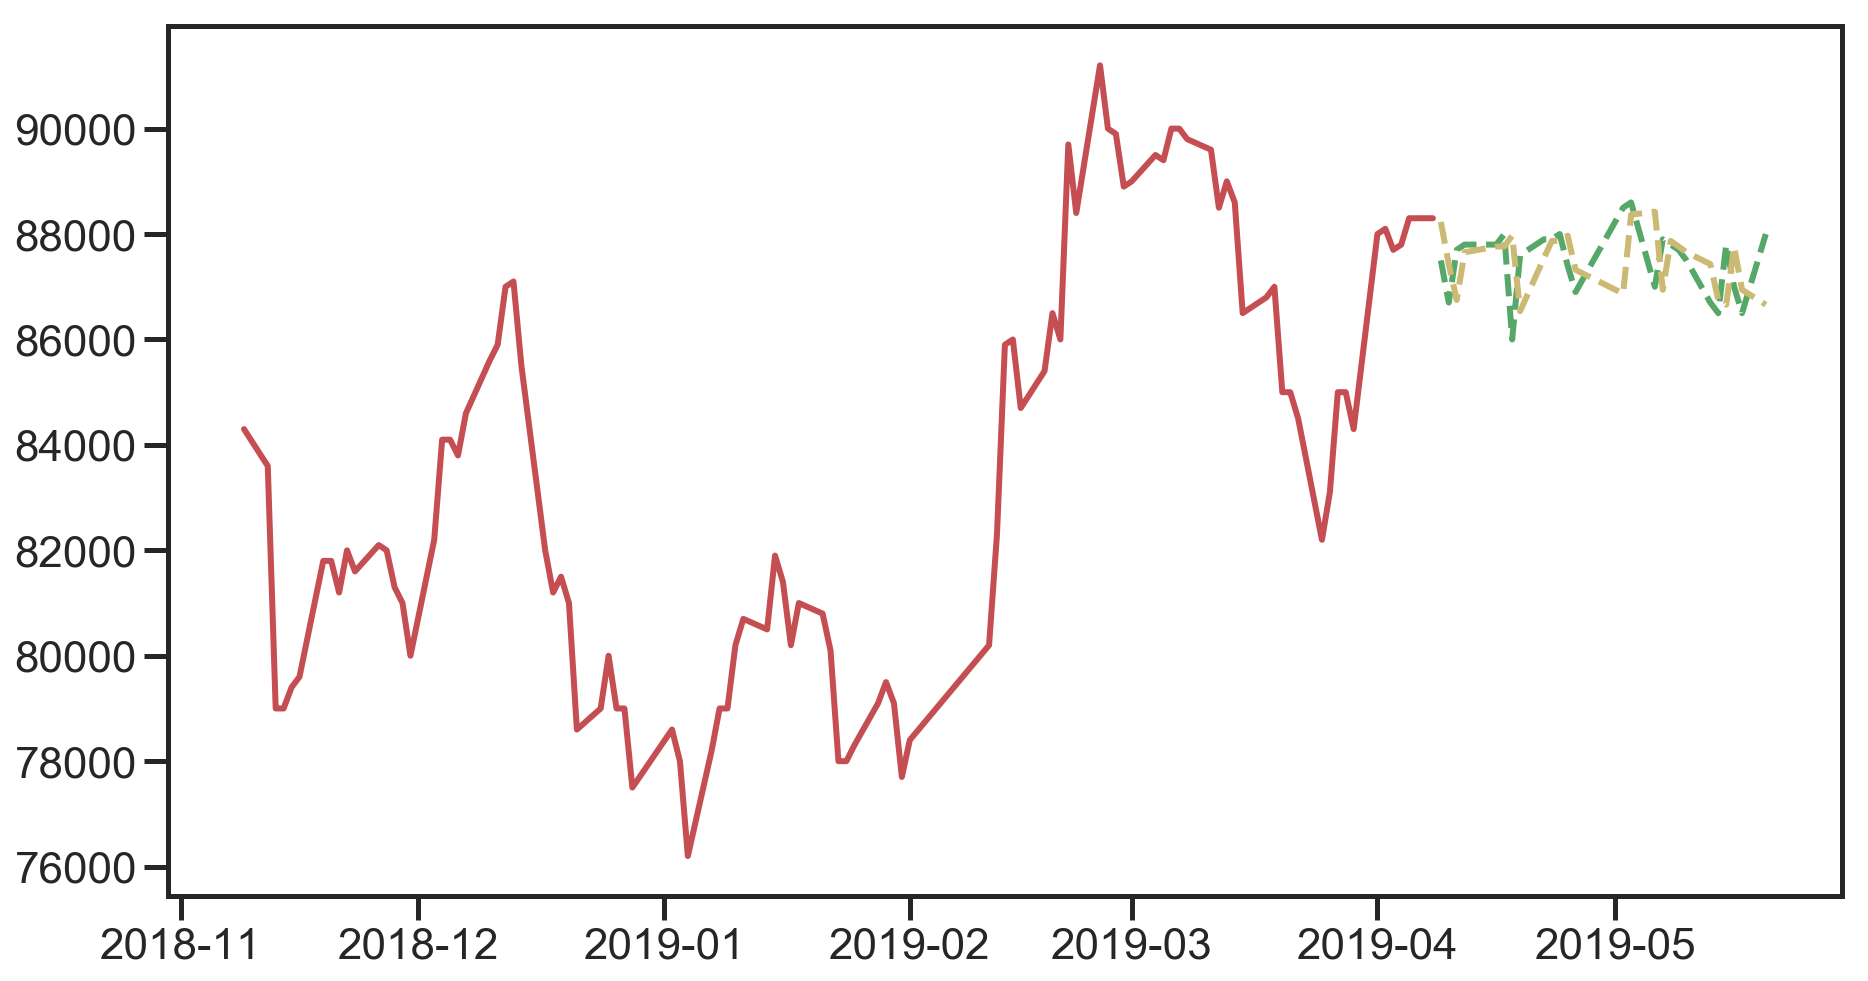

date
2019-04-09   88230.63959
2019-04-10   87430.70820
2019-04-11   86748.65033
2019-04-12   87653.88496
2019-04-16   87763.49819
2019-04-17   87763.49819
2019-04-18   87969.82564
2019-04-19   86536.68055
2019-04-22   87542.27166
2019-04-23   87869.30277
2019-04-24   87869.30277
2019-04-25   87969.82564
2019-04-26   87321.34585
2019-05-02   86869.37161
2019-05-03   88367.43321
2019-05-06   88425.11051
2019-05-07   86943.13845
2019-05-08   87869.30277
2019-05-09   87763.49819
2019-05-10   87653.88496
2019-05-13   87430.70820
2019-05-14   86748.65033
2019-05-15   86660.03699
2019-05-16   87763.49819
2019-05-17   86943.13845
2019-05-20   86660.03699
dtype: float64


In [14]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    start_train = 0.9
    end_train = 0.98
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result = run_model_with_parameters(train, test, model_selection='ANN', lag=1, hidden_layers=(6,3))
    if result['status']:
        validation = result['model'].validate(test)
        time.sleep(1)
        print(ticket)
        print('Training result:', result['train_evaluation'])
        print('Testing result:', result['test_evaluation'])
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        ax1.plot(train, label='in-sample', color='r', linestyle='-')
        ax1.plot(test, label='held-out', color='g', linestyle='--')
        ax1.plot(validation, label='predicted held-out', color='y', linestyle='--')
    #     ax1.plot(df_ann_validation['yhat'], label='validation held-out', color='purple', linestyle='--')
        plt.show()
    else:
        print('None')
    print(validation)

### Hybrid model

Masan Group Corp
Training result: {'mse': 2962389.579405186, 'rmse': 1721.1593707164907, 'mae': 1268.9596187964858, 'mape': 1.506926437990667}
Testing result: {'mse': 1610799.9054335123, 'rmse': 1269.1729218012463, 'mae': 1008.659720531085, 'mape': 1.1581244133914859}


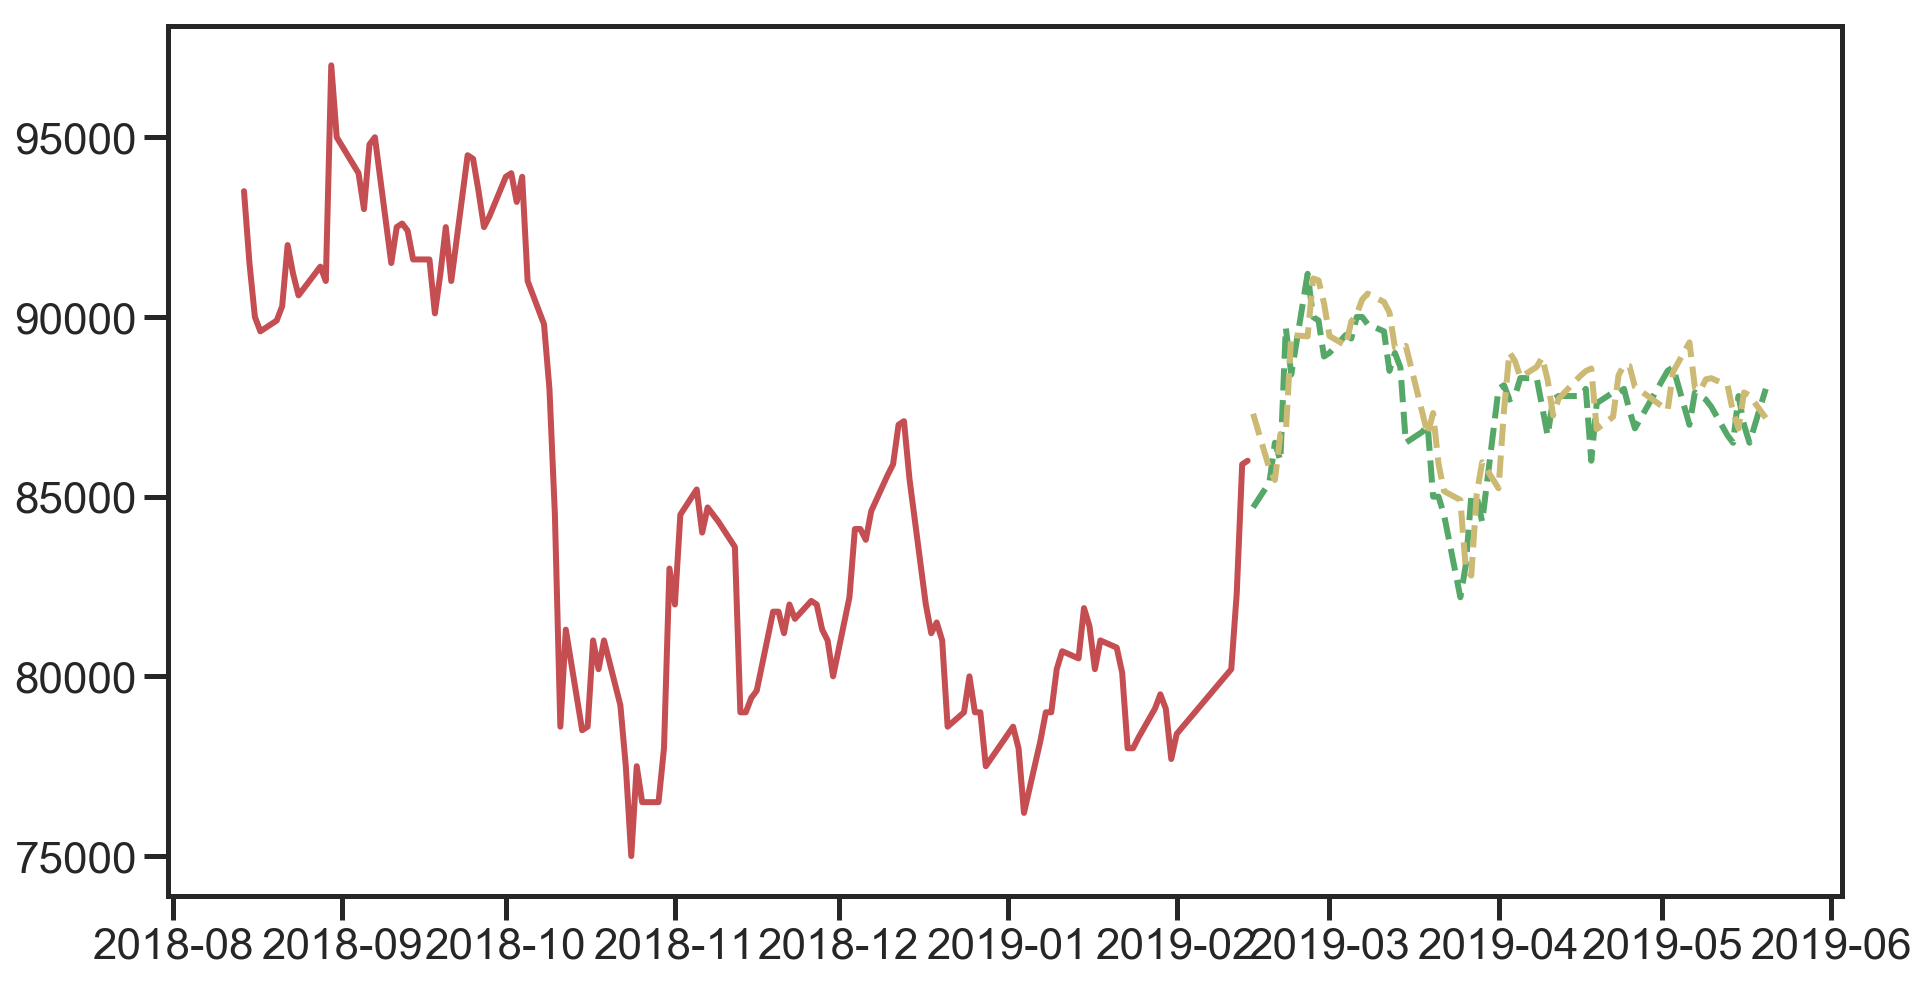

In [11]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    start_train = 0.85
    end_train = 0.95
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result = run_model_with_parameters(train, test, model_selection='Hybrid', order=(1, 1, 3), lag=2, hidden_layers=(6, 1))
    if result['status']:
        validation = result['model'].validate(test)
        time.sleep(1)
        print(ticket)
        print('Training result:', result['train_evaluation'])
        print('Testing result:', result['test_evaluation'])
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        ax1.plot(train, label='in-sample', color='r', linestyle='-')
        ax1.plot(test, label='held-out', color='g', linestyle='--')
        ax1.plot(validation, label='predicted held-out', color='y', linestyle='--')
    #     ax1.plot(df_ann_validation['yhat'], label='validation held-out', color='purple', linestyle='--')
        plt.show()
    else:
        print('None')

### Run model without parameters

In [12]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    start_train = 0.85
    end_train = 0.95
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result, lst_result = run_model_without_parameters(train, test, model_selection='Hybrid', q=range(0, 4))
    print(ticket, ':', result['lag'], result['hidden_layers'], result['order'])


Masan Group Corp : 2 (6, 1) (1, 1, 3)


In [13]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    start_train = 0.85
    end_train = 0.95
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result, lst_result = run_model_without_parameters(train, test, model_selection='ARIMA', q=range(0, 4))
    print(ticket, ':', result['order'])


Masan Group Corp : (1, 0, 0)


In [14]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    start_train = 0.85
    end_train = 0.95
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result, lst_result = run_model_without_parameters(train, test, model_selection='ANN', q=range(0, 4))
    print(ticket, ':', result['lag'], result['hidden_layers'])


Masan Group Corp : 1 (6, 3)


In [15]:
# print(result['test_evaluation'])
# lst_dct_result = list()
# for result_ in lst_result:
#     lst_dct_result.append({
#         'order': result_['order'],
#         'mse': result_['test_evaluation']['mse'],
#         'rmse': result_['test_evaluation']['rmse'],
#         'mae': result_['test_evaluation']['mae'],
#         'mape': result_['test_evaluation']['mape'],
#     })
# df_result = pd.DataFrame(data=lst_dct_result)
# df_result.head(20)